![Logo Universidad Galileo](assets/Logo_Universidad_Galileo.png)

# **Lab 1: Prediction of energy prices using multiple regression**
## Course: Statistical Learning
### Student: Otto Chamo


# Libraries

Python libraries and scripts used to work on this assignment

In [18]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import PolynomialFeatures, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge

import utils as utils
from correlation_plot_args import CorrelationPlotArgs


# Constants

Defining all the constant values we are gonna use in the whole codebase. Column names, common values, etc.

In [20]:
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

sheet_names = ["ENERO", "FEBRERO", "MARZO", "ABRIL", "MAYO", "JUNIO", "JULIO", "AGOSTO", "SEPTIEMBRE", "OCTUBRE", "NOVIEMBRE", "DICIEMBRE"]
days_of_each_month = {'ENERO': 31, 'FEBRERO': 28, 'MARZO': 31, 'ABRIL': 30, 'MAYO': 31, 'JUNIO': 30, 'JULIO': 31, 'AGOSTO': 31, 'SEPTIEMBRE': 30, 'OCTUBRE': 31, 'NOVIEMBRE': 30, 'DICIEMBRE': 31}

dataset_excel_file_path = "./POE_2023.xlsx"

month_col = "month"
month_sin_col = "month_sin"
month_cos_col = "month_cos"
electricity_price_col = "electricityPrice"
hour_of_day_col = "hourOfDay"
hour_of_day_sin_col = "hourOfDay_sin"
hour_of_day_cos_col = "hourOfDay_cos"
day_col = "day"
day_sin_col = "day_sin"
day_cos_col = "day_cos"
date_col = "date"
day_of_week_col = "dayOfWeek"
day_of_week_sin_col = "dayOfWeek_sin"
day_of_week_cos_col = "dayOfWeek_cos"
hora_inicio_col = "horaInicio"
hora_fin_col = "HoraFin"

axis_col = 0

axis_row = 1

# 1. Loading data

In [21]:
datasetExcel = pd.read_excel(dataset_excel_file_path, sheet_name=sheet_names)

# Pre processing

Before applying feature engineering we have to convert the structure of our dataset in way that represents the known structure of a linear regression model.

$ y = mx+b$

In [22]:
dataframeAllData: pd.DataFrame = pd.DataFrame(columns=[electricity_price_col, month_col, hour_of_day_col, day_col, date_col])

In [23]:
for monthIndex, sheetName in enumerate(sheet_names):
    monthDataFrame: pd.DataFrame = datasetExcel[sheetName]
    monthDataFrame: pd.DataFrame = monthDataFrame.drop(hora_inicio_col, axis=1)
    monthDataFrame: pd.DataFrame = monthDataFrame.drop(hora_fin_col, axis=1)
    amountOfMonthDays = monthDataFrame.columns.size

    currentMonth = monthIndex + 1
    #print("currentMonth = ", sheetName)
    #print("columns = ", monthDataFrame.columns)
    #print("columns = ", monthDataFrame.columns.size)
    for day in range(0, days_of_each_month[sheetName]):
       col = day + 1
       startDay = int(day + 1)
       startDate = datetime.datetime(year = 2023, month=currentMonth, day=startDay)
       pricesFrame: pd.DataFrame = monthDataFrame[col].to_frame(name=electricity_price_col)
       pricesFrame[month_col] = currentMonth
       pricesFrame[hour_of_day_col] = range(len(pricesFrame))
       pricesFrame[day_col] = startDay
       pricesFrame[date_col] = startDate
       pricesFrame[day_of_week_col] = utils.findDay(startDate.year, startDate.month, startDate.day)
       dataframeAllData = pd.concat([dataframeAllData, pricesFrame], ignore_index=True)
       #print(dataframeAllData)
#print(dataframeAllData)
#dataframeAllData.to_excel('output.xlsx')



Once we have the data converted to the structure we need, we cast the data types we want to work with

In [24]:
dataframeAllData[month_col] = pd.to_numeric(dataframeAllData[month_col], errors='coerce').astype('int')
dataframeAllData[hour_of_day_col] = pd.to_numeric(dataframeAllData[hour_of_day_col], errors='coerce').astype('int')
dataframeAllData[day_col] = pd.to_numeric(dataframeAllData[day_col], errors='coerce').astype('int')
dataframeAllData[day_of_week_col] = pd.to_numeric(dataframeAllData[day_of_week_col], errors='coerce').astype('int')

In [25]:
missing_values_sum = dataframeAllData.isnull().sum()


missing_values_sum

electricityPrice    0
month               0
hourOfDay           0
day                 0
date                0
dayOfWeek           0
dtype: int64

In [26]:
dataframeAllData.dtypes

electricityPrice           float64
month                        int32
hourOfDay                    int32
day                          int32
date                datetime64[ns]
dayOfWeek                    int32
dtype: object

In [27]:
dataframeAllData.describe()

,electricityPrice,month,hourOfDay,day,date,dayOfWeek
count,8760.000000,8760.000000,8760.000000,8760.000000,8760,8760.000000
mean,105.337933,6.526027,11.500000,15.720548,2023-07-02 00:00:00,3.008219
min,0.875239,1.000000,0.000000,1.000000,2023-01-01 00:00:00,0.000000
25%,76.887585,4.000000,5.750000,8.000000,2023-04-02 00:00:00,1.000000
50%,104.907165,7.000000,11.500000,16.000000,2023-07-02 00:00:00,3.000000
75%,128.688128,10.000000,17.250000,23.000000,2023-10-01 00:00:00,5.000000
max,452.592708,12.000000,23.000000,31.000000,2023-12-31 00:00:00,6.000000
std,51.798399,3.448048,6.922582,8.796749,NaN,2.003519


## Adding cyclical encoding columns

We do this in order for the model to learn a relationship of cycle between the values of the data

In [28]:
dataframeAllData = utils.cyclical_encoding(dataframeAllData, month_col, 12)
dataframeAllData = utils.cyclical_encoding(dataframeAllData, day_col, 31)
dataframeAllData = utils.cyclical_encoding(dataframeAllData, day_of_week_col, 6)
dataframeAllData = utils.cyclical_encoding(dataframeAllData, hour_of_day_col, 23)

In [29]:
dataframeAllData

,electricityPrice,month,hourOfDay,day,date,dayOfWeek,month_sin,month_cos,day_sin,day_cos,dayOfWeek_sin,dayOfWeek_cos,hourOfDay_sin,hourOfDay_cos
0,74.231420,1,0,1,2023-01-01,6,5.000000e-01,5.000000e-01,2.012985e-01,2.012985e-01,-2.449294e-16,-2.449294e-16,0.000000e+00,0.000000e+00
1,74.231420,1,1,1,2023-01-01,6,5.000000e-01,5.000000e-01,2.012985e-01,2.012985e-01,-2.449294e-16,-2.449294e-16,2.697968e-01,2.697968e-01
2,59.075180,1,2,1,2023-01-01,6,5.000000e-01,5.000000e-01,2.012985e-01,2.012985e-01,-2.449294e-16,-2.449294e-16,5.195840e-01,5.195840e-01
3,59.075180,1,3,1,2023-01-01,6,5.000000e-01,5.000000e-01,2.012985e-01,2.012985e-01,-2.449294e-16,-2.449294e-16,7.308360e-01,7.308360e-01
4,80.961495,1,4,1,2023-01-01,6,5.000000e-01,5.000000e-01,2.012985e-01,2.012985e-01,-2.449294e-16,-2.449294e-16,8.878852e-01,8.878852e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,18.589755,12,19,31,2023-12-31,6,-2.449294e-16,-2.449294e-16,-2.449294e-16,-2.449294e-16,-2.449294e-16,-2.449294e-16,-8.878852e-01,-8.878852e-01
8756,18.589755,12,20,31,2023-12-31,6,-2.449294e-16,-2.449294e-16,-2.449294e-16,-2.449294e-16,-2.449294e-16,-2.449294e-16,-7.308360e-01,-7.308360e-01
8757,15.905671,12,21,31,2023-12-31,6,-2.449294e-16,-2.449294e-16,-2.449294e-16,-2.449294e-16,-2.449294e-16,-2.449294e-16,-5.195840e-01,-5.195840e-01
8758,11.097906,12,22,31,2023-12-31,6,-2.449294e-16,-2.449294e-16,-2.449294e-16,-2.449294e-16,-2.449294e-16,-2.449294e-16,-2.697968e-01,-2.697968e-01


## 1.3 Visualize relationship between predicting variable and the variable we want to predict.

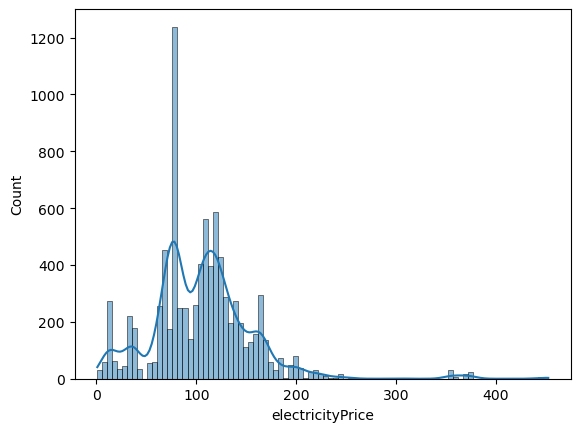

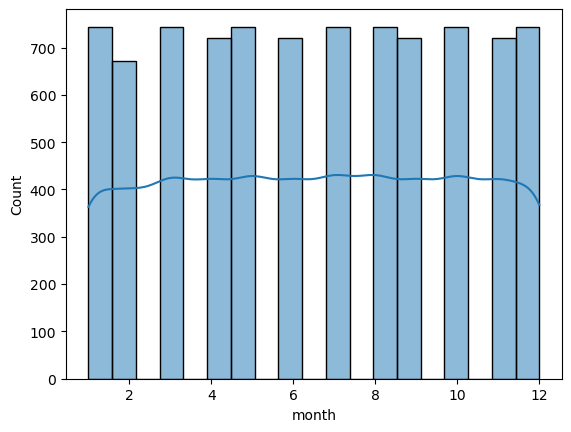

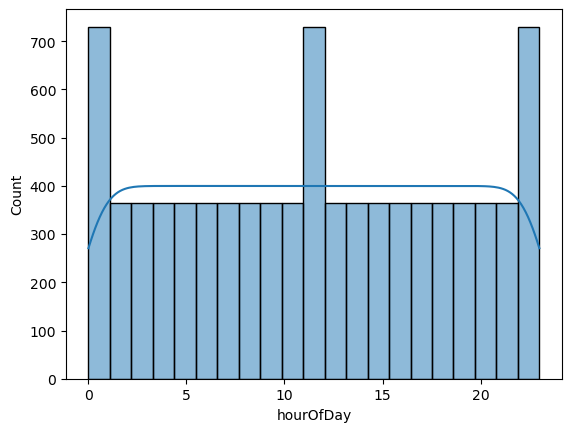

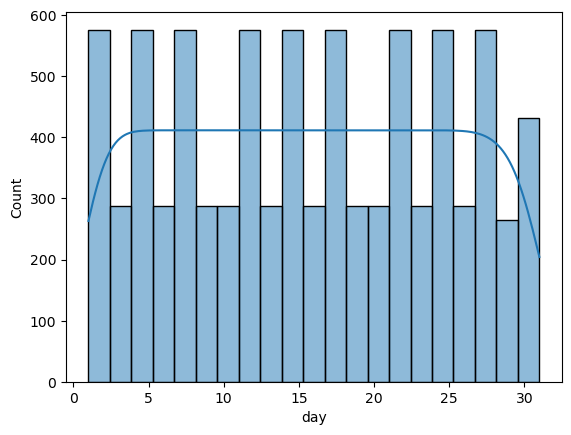

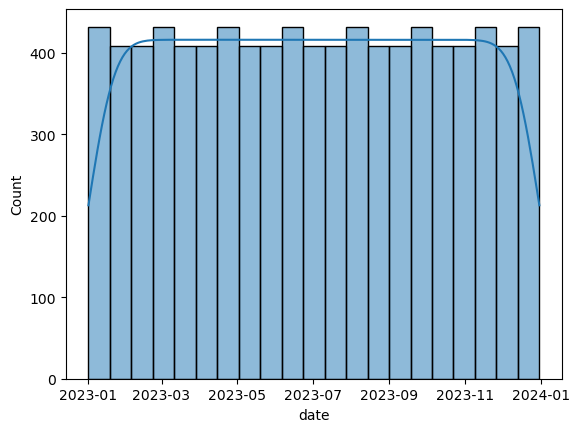

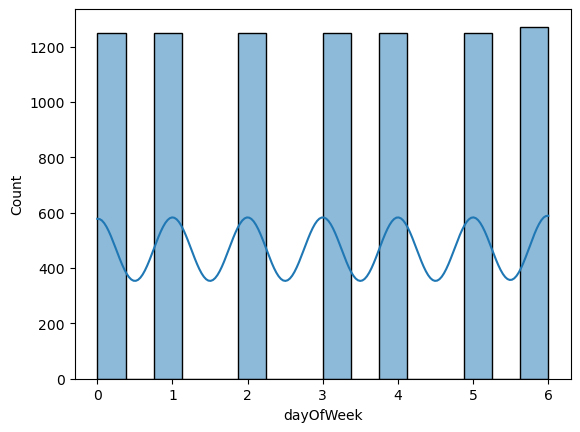

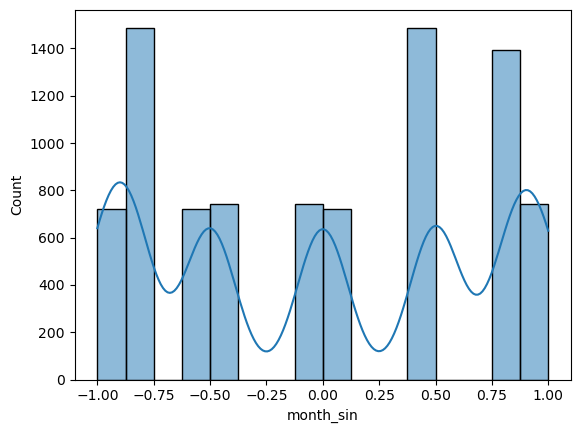

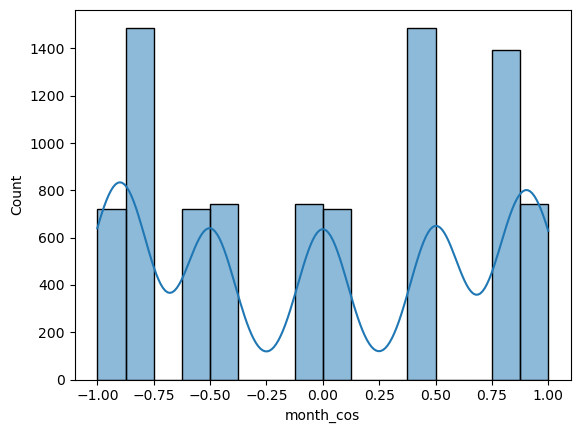

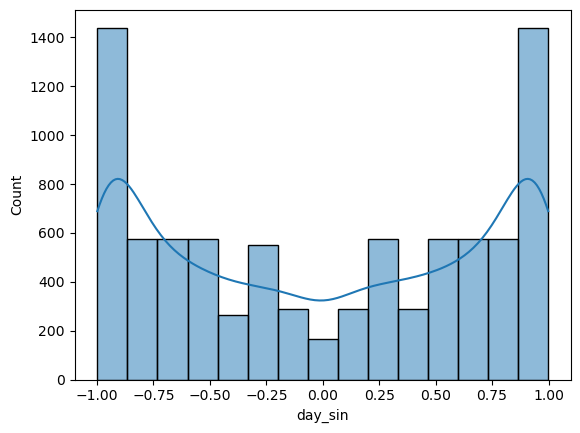

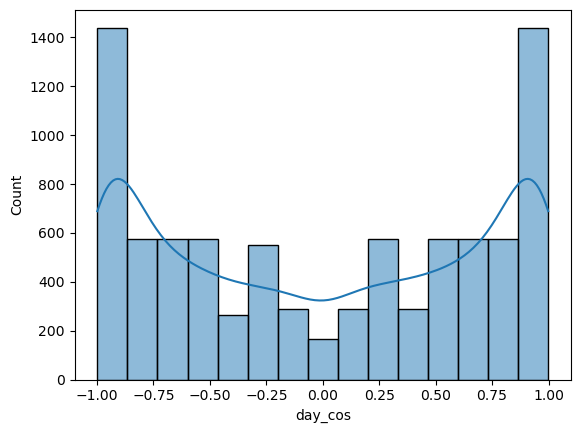

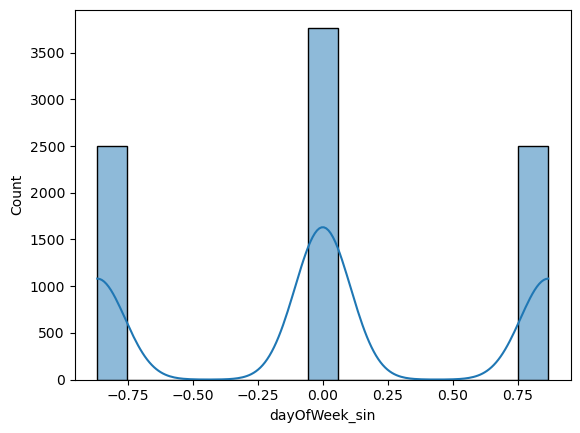

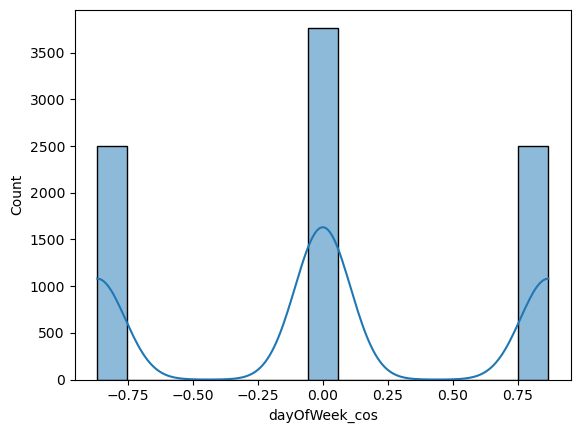

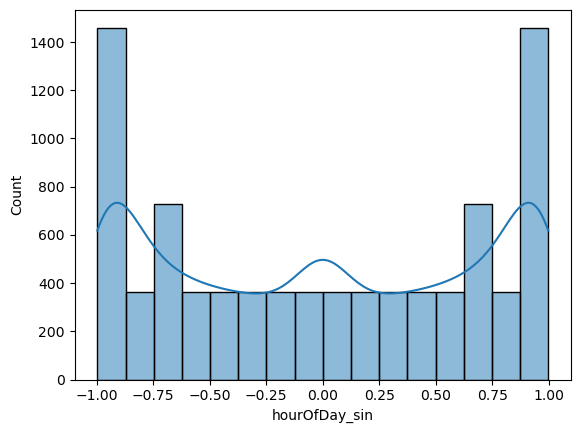

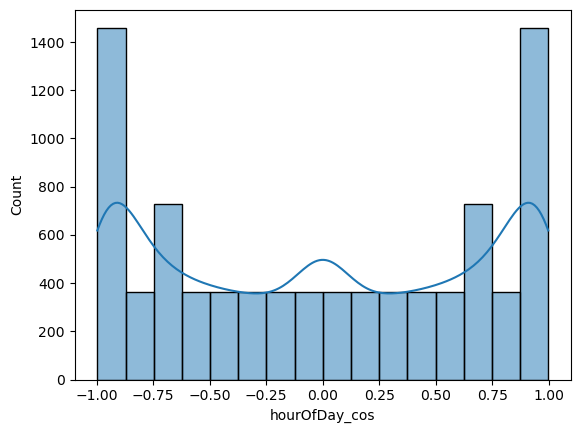

In [30]:
utils.plot_columns(dataframeAllData)

## Applying log transform to electricity price because it has a positive bias

In [31]:
dataframeAllData[electricity_price_col] = np.log(dataframeAllData[electricity_price_col])


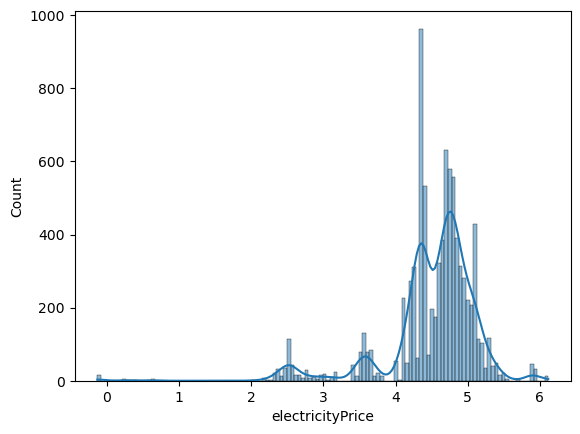

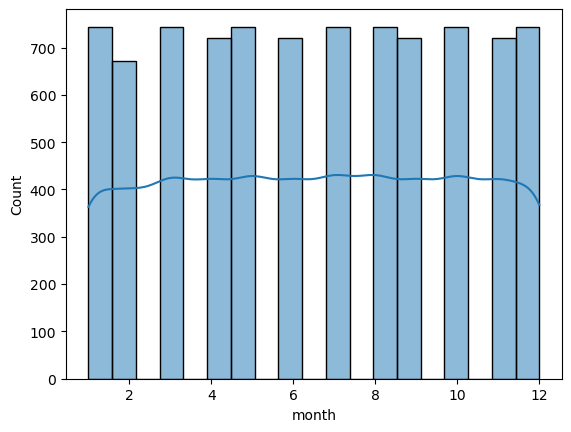

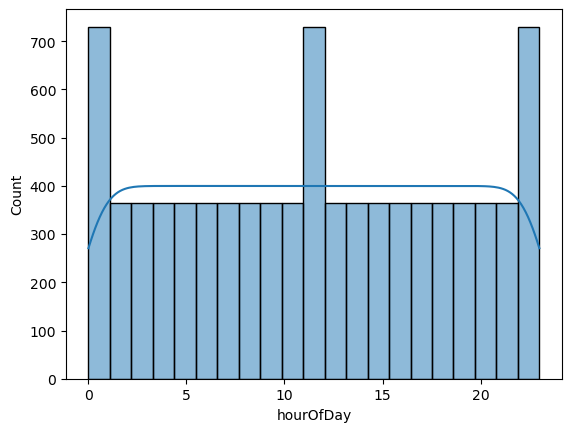

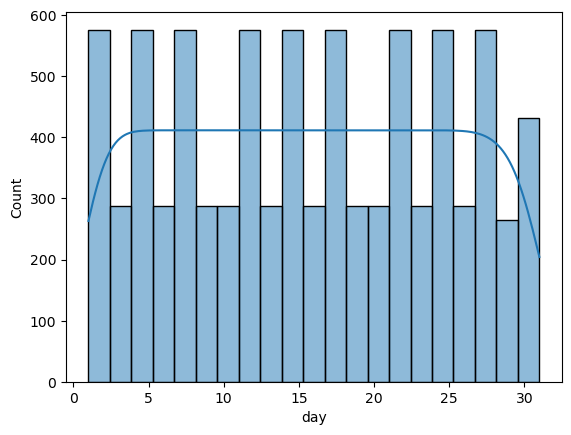

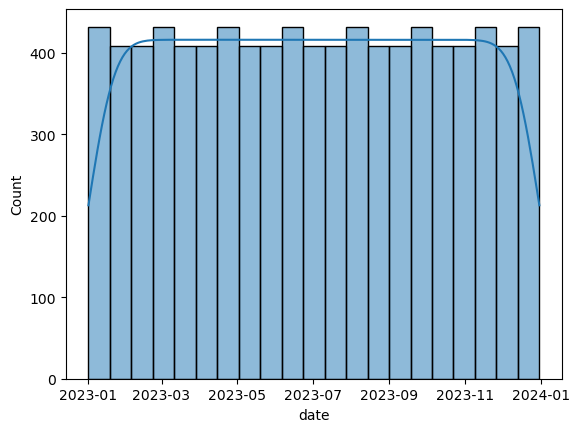

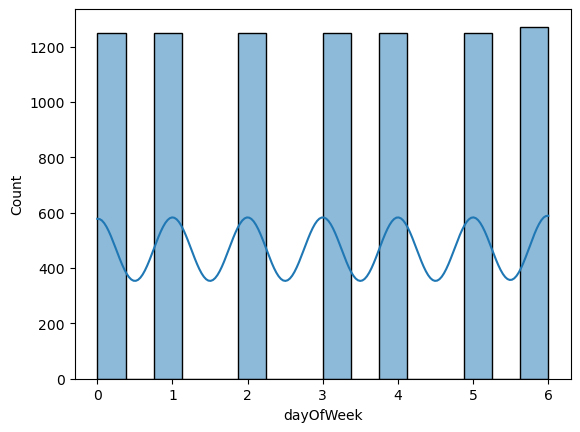

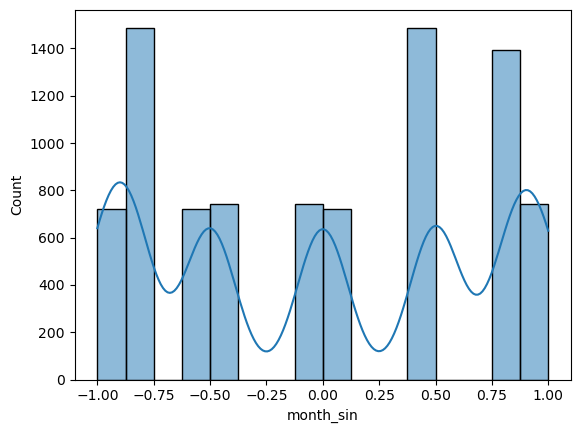

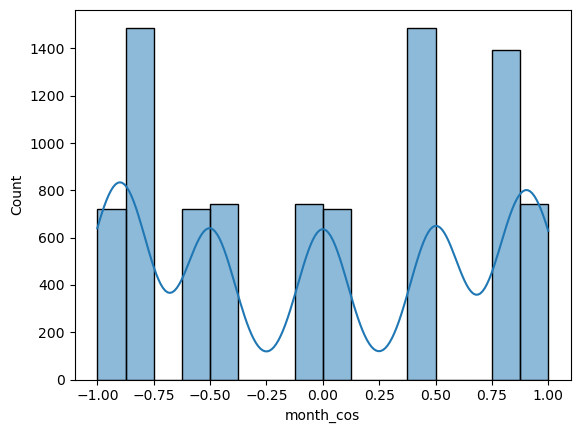

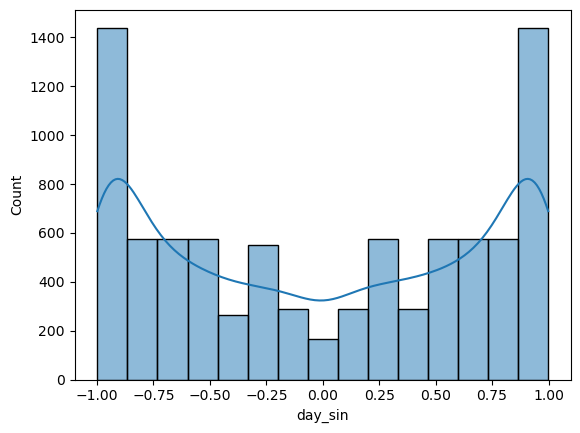

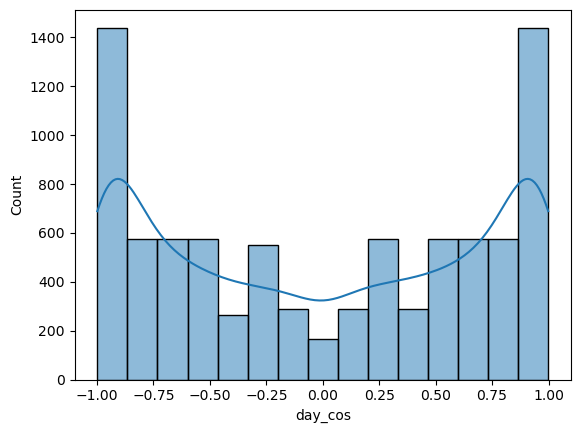

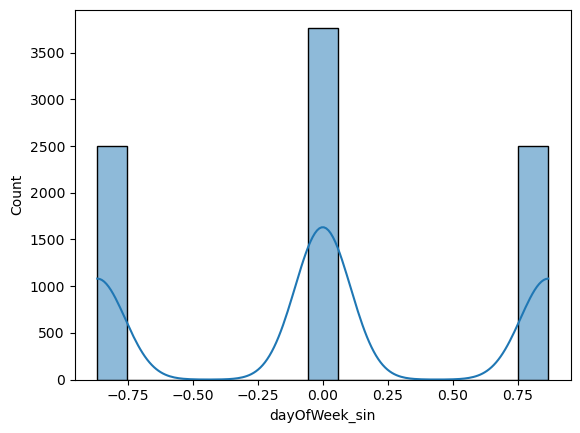

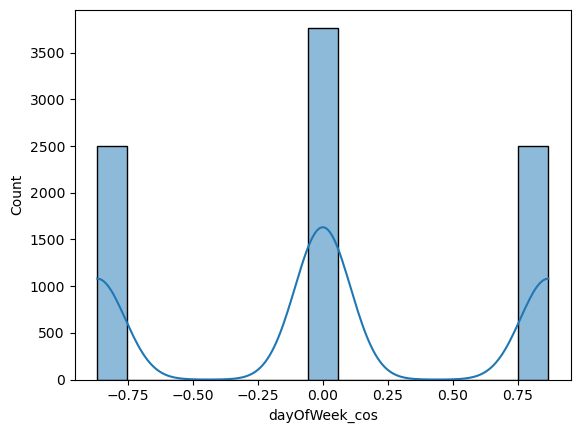

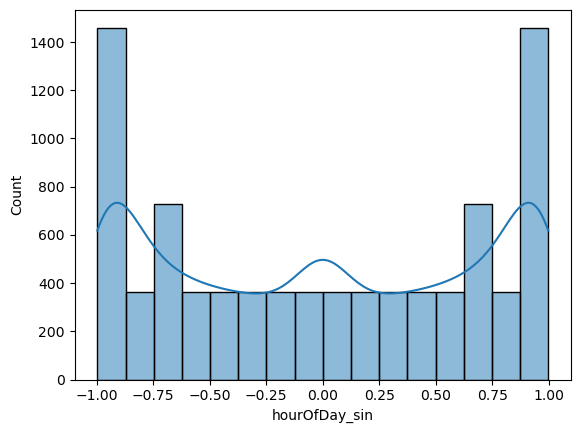

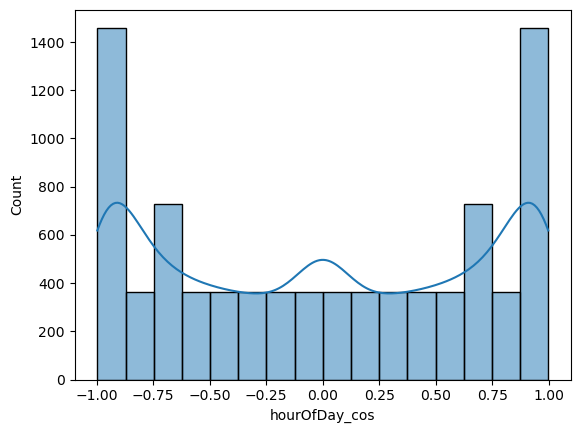

In [32]:
utils.plot_columns(dataframeAllData)

In [33]:
salesPrices = dataframeAllData[electricity_price_col]
datasetToWork = dataframeAllData.copy().drop(electricity_price_col, axis = 1)
dataset_train, dataset_test, prices_train, prices_test = train_test_split(datasetToWork, salesPrices, test_size=0.2)

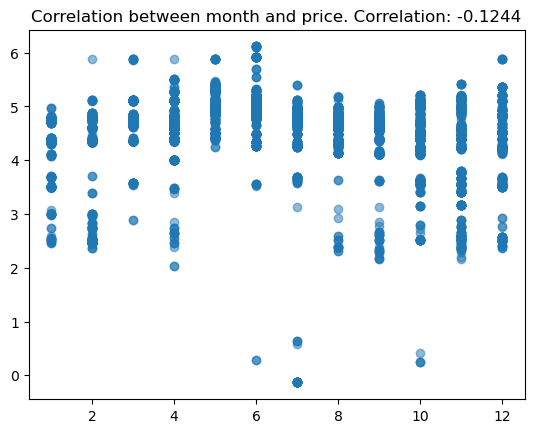

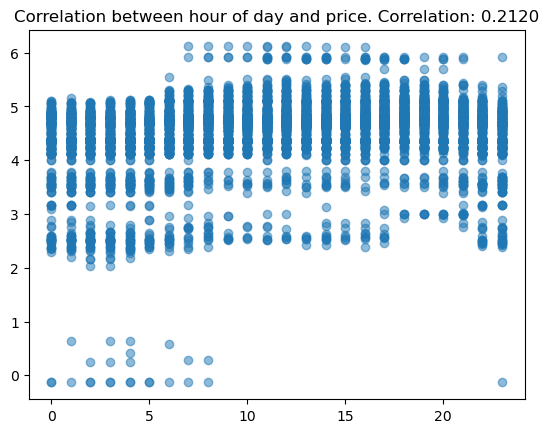

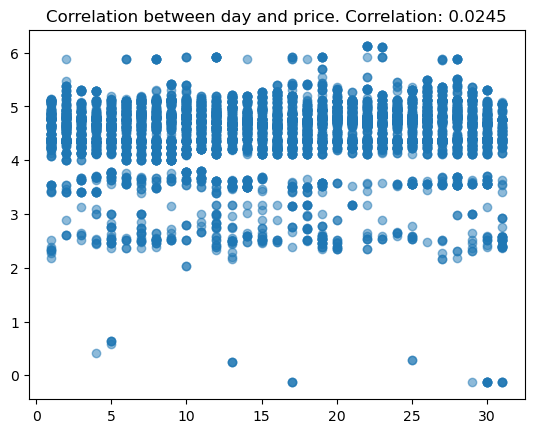

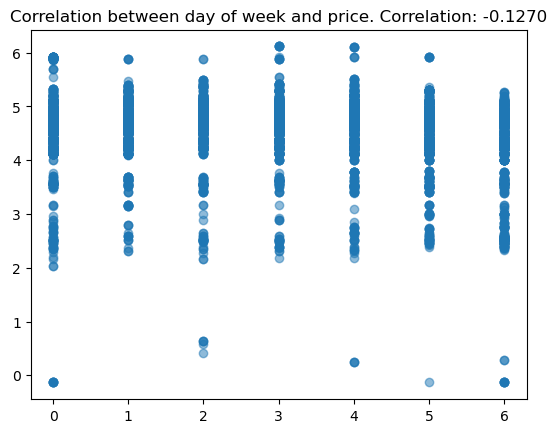

In [34]:
correlation =  utils.calculateCorrelation(dataset_train[month_col].astype('int'), prices_train)
args = CorrelationPlotArgs(
    x = dataset_train[month_col],
    y = prices_train,
    correlation = correlation[0, 1],
    title = "Correlation between month and price"
)

utils.plotScatterPlot(args)

correlation =  utils.calculateCorrelation(dataset_train[hour_of_day_col].astype('int'), prices_train)
args = CorrelationPlotArgs(
    x = dataset_train[hour_of_day_col],
    y = prices_train,
    correlation = correlation[0, 1],
    title = "Correlation between hour of day and price"
)

utils.plotScatterPlot(args)

correlation =  utils.calculateCorrelation(dataset_train[day_col].astype('int'), prices_train)
args = CorrelationPlotArgs(
    x = dataset_train[day_col],
    y = prices_train,
    correlation = correlation[0, 1],
    title = "Correlation between day and price"
)

utils.plotScatterPlot(args)

correlation =  utils.calculateCorrelation(dataset_train[day_of_week_col].astype('int'), prices_train)
args = CorrelationPlotArgs(
    x = dataset_train[day_of_week_col],
    y = prices_train,
    correlation = correlation[0, 1],
    title = "Correlation between day of week and price"
)

utils.plotScatterPlot(args)

## Model evaluation function

In [138]:
def evaluate_model(model, X, y, cv=5):

    y_pred = model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error')
    r2 = r2_score(y, y_pred)
    try:
        reg_coef = model.coef_
    except:
        reg_coef = 'coef_ attribute not found'
    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'CV MAE': -np.mean(scores),
        'r^2': r2,
        'pred': y_pred,
        'coef': reg_coef
    }

def print_result_metrics(data):
    print("Resultados de la regresión:")
    print(f"MAE: {data['MAE']}")
    print(f"MSE: {data['MSE']}")
    print(f"RMSE: {data['RMSE']}")
    print(f"CV MAE: {data['CV MAE']}")
    print(f"R^2: {data['r^2']}")
    print(f"coefficients: {data['coef']}")

def plot_results(pred, real):
    plt.figure(figsize=(8, 6))
    plt.scatter(real, pred, color='orange', label='Prediction')
    plt.plot([min(real), max(real)], [min(real), max(real)], color='blue', linestyle='--', label='Reference')
    plt.title('True prices vs Predicted')
    plt.xlabel('True prices')
    plt.ylabel('Predicted')
    plt.legend()
    plt.show()


# Linear regression Model

## Linear regression multiple

Resultados de la regresión:
MAE: 0.42092646151351076
MSE: 0.39201837946327145
RMSE: 0.6261137112883501
CV MAE: 0.41749051422035865
R^2: 0.06064691989367166
coefficients: [-0.02363757  0.01993471]


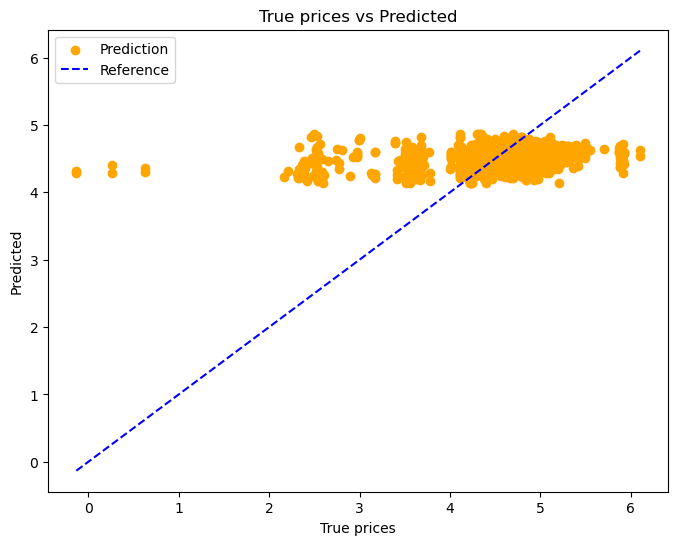

In [139]:
linearRegressionMultiple = LinearRegression()
x_multiple = dataset_train[[month_col, hour_of_day_col]].values
x_multiple_test = dataset_test[[month_col,hour_of_day_col]].values
x_multiple_cyclical = dataset_train[[month_cos_col, month_sin_col, hour_of_day_cos_col, hour_of_day_sin_col]].values
x_multiple_test_cyclical = dataset_test[[month_cos_col, month_sin_col, hour_of_day_cos_col, hour_of_day_sin_col]].values
y = prices_train.values

linearRegressionMultiple.fit(x_multiple, y)

resultsMultiple = evaluate_model(linearRegressionMultiple, x_multiple_test, prices_test)

print_result_metrics(resultsMultiple)
plot_results(resultsMultiple['pred'], prices_test)


## Linear regression multiple cyclical

Resultados de la regresión:
MAE: 0.4194894686517263
MSE: 0.3879220125170394
RMSE: 0.6228338562707068
CV MAE: 0.4169564213036141
R^2: 0.0704626201510351
coefficients: [ 4.95651128e-02  4.95368456e-02  1.63991966e+13 -1.63991966e+13]


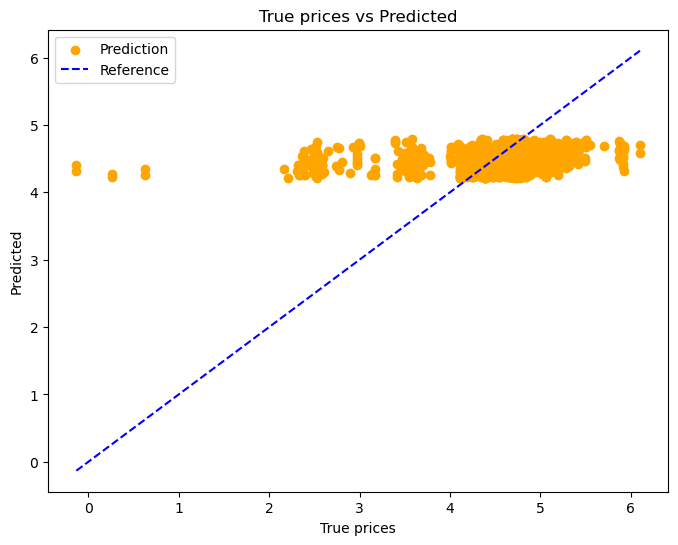

In [140]:
linearRegressionMultiple.fit(x_multiple_cyclical, y)

resultsMultiple = evaluate_model(linearRegressionMultiple, x_multiple_test_cyclical, prices_test)


print_result_metrics(resultsMultiple)
plot_results(resultsMultiple['pred'], prices_test)


## Linear regression model polynomial

In [141]:
linearRegresionModelPoly = LinearRegression()
poly = PolynomialFeatures(2)
x_multiple = dataset_train[[month_col, hour_of_day_col, day_of_week_col]].values
x_multiple_test = dataset_test[[month_col,hour_of_day_col, day_of_week_col]].values
y = prices_train.values

In [142]:
x_poly = poly.fit_transform(x_multiple)
x_test_poly = poly.fit_transform(x_multiple_test)

Resultados de la regresión:
MAE: 0.3609422428995335
MSE: 0.3166960842463998
RMSE: 0.5627575714696336
CV MAE: 0.35906127794277254
R^2: 0.24113394223563211
coefficients: [ 0.          0.17078849  0.08066996  0.10277992 -0.01956783  0.00316813
  0.00786197 -0.0031436  -0.00299503 -0.02652243]


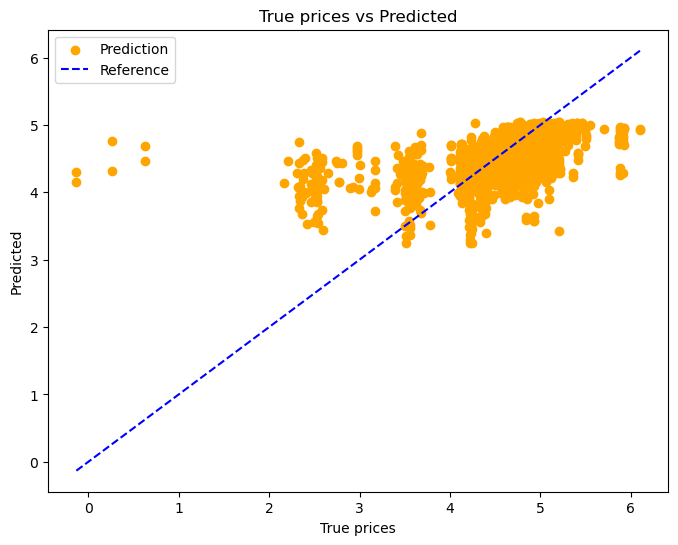

In [143]:
linearRegresionModelPoly.fit(x_poly, y)

resultsPoly = evaluate_model(linearRegresionModelPoly, x_test_poly, prices_test)

print_result_metrics(resultsPoly)
plot_results(resultsPoly['pred'], prices_test)


## Linear Regression cyclical encoding

In [150]:
linearRegresionModelPoly = LinearRegression()
poly = PolynomialFeatures(2)
x = dataset_train[[month_sin_col, month_cos_col, hour_of_day_sin_col, hour_of_day_cos_col, day_of_week_cos_col, day_of_week_sin_col]].values
x_test = dataset_test[[month_sin_col, month_cos_col, hour_of_day_sin_col, hour_of_day_cos_col, day_of_week_cos_col, day_of_week_sin_col]].values
y = prices_train.values
x_poly = poly.fit_transform(x)
x_test_poly = poly.fit_transform(x_test)

Resultados de la regresión:
MAE: 0.4206220765494792
MSE: 0.3826953828488648
RMSE: 0.6186237813476497
CV MAE: 0.42029763574876294
R^2: 0.08298665201938005
coefficients: [-5.88981092e+09 -5.83595583e+09  5.83595583e+09  1.49194305e+10
 -1.49194305e+10 -1.39477010e+10  1.39477010e+10 -2.04432382e+10
  1.26273096e+10 -1.44877664e+10  4.82925545e+09 -2.92755849e+12
  2.33814221e+11  7.81592851e+09  4.82925545e+09  4.82925545e+09
  1.34687214e+12  1.34687214e+12  2.55317826e+09 -1.27658913e+09
 -9.20091604e+11 -2.24569067e+12 -1.27658913e+09 -2.24569067e+12
  5.41147295e+12 -5.77769089e+09 -3.09433145e+09  8.87202234e+09]


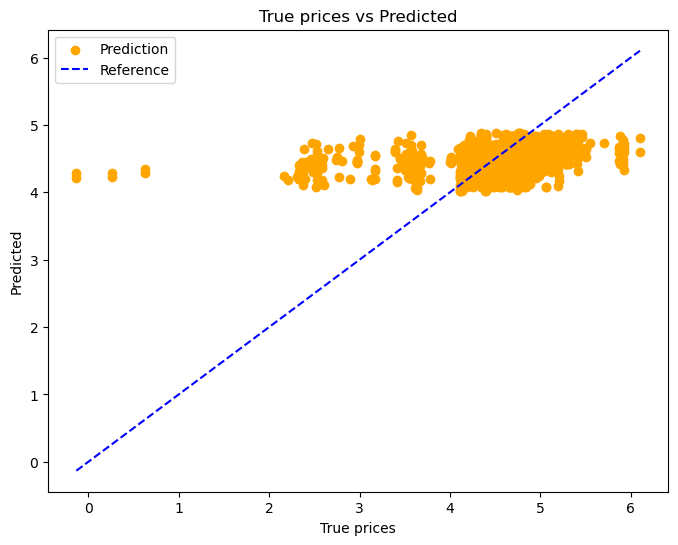

In [151]:
linearRegresionModelPoly.fit(x_poly, y)

resultsPoly = evaluate_model(linearRegresionModelPoly, x_test_poly, prices_test)

print_result_metrics(resultsPoly)

plot_results(resultsPoly['pred'], prices_test)


In [146]:
linearRegresionModelPoly = LinearRegression()
poly = PolynomialFeatures(2)
x = dataset_train[[month_sin_col, month_cos_col, hour_of_day_sin_col, hour_of_day_cos_col, day_of_week_sin_col, day_of_week_cos_col, day_sin_col, day_cos_col]].values
x_test = dataset_test[[month_sin_col, month_cos_col, hour_of_day_sin_col, hour_of_day_cos_col, day_of_week_sin_col, day_of_week_cos_col, day_sin_col, day_cos_col]].values
y = prices_train.values
x_poly = poly.fit_transform(x)
x_test_poly = poly.fit_transform(x_test)

Resultados de la regresión:
MAE: 0.4198051484298739
MSE: 0.3808901859847429
RMSE: 0.6171630141095162
CV MAE: 0.423001713731992
R^2: 0.08731225847903856
coefficients: [ 2.10781312e+11 -1.22854772e+13  1.22854772e+13 -1.52706514e+13
  1.52706514e+13  7.93076408e+12 -7.93076408e+12  2.07636689e+13
 -2.07636689e+13  2.25041858e+13 -1.68327876e+13  1.04388351e+13
 -5.10226402e+12 -2.98841028e+13 -3.84512986e+12  2.62931839e+13
 -2.83599056e+12 -5.67139814e+12 -2.66828555e+12 -2.66828555e+12
  1.68646163e+13  1.68646163e+13 -1.17285967e+13 -1.17285967e+13
  7.36571819e+11 -3.68285910e+11  8.96685302e+12  4.51900897e+12
 -1.75571634e+13  2.82159826e+13 -3.68285910e+11  4.51900897e+12
 -1.80048710e+13 -5.32940961e+12 -5.32940961e+12 -1.98220859e+11
  9.91104294e+10  6.52736776e+12  7.42824753e+12  9.91104294e+10
 -6.97780765e+12 -6.97780765e+12  2.09948979e+12  9.31719361e+11
 -3.03120915e+12]


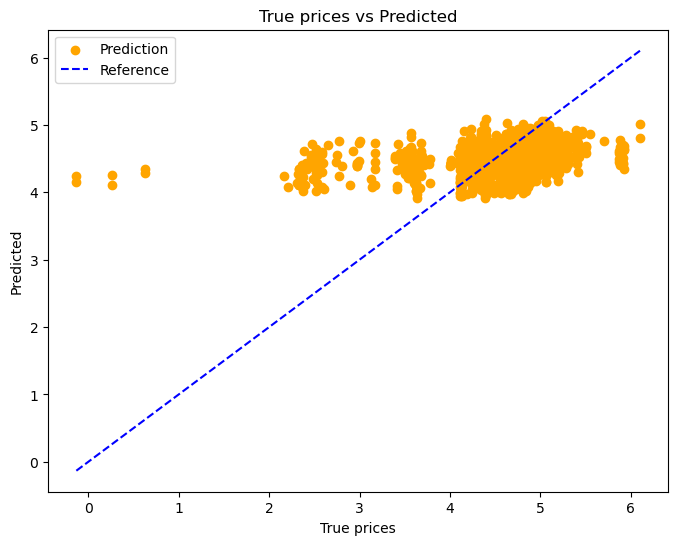

In [147]:
linearRegresionModelPoly.fit(x_poly, y)

resultsPoly = evaluate_model(linearRegresionModelPoly, x_test_poly, prices_test)

print_result_metrics(resultsPoly)
plot_results(resultsPoly['pred'], prices_test)


## Lasso Linear regression

Resultados de la regresión:
MAE: 0.4359846278956658
MSE: 0.4174601526553606
RMSE: 0.6461115636291929
CV MAE: 0.4344128703852255
R^2: -0.00031656871641949635
coefficients: coef_ attribute not found


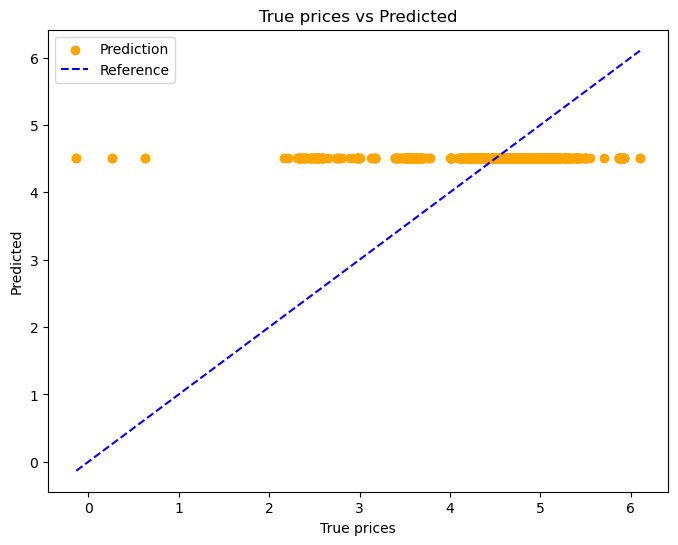

In [148]:
pipeline_lasso = Pipeline([
     ('scaler', RobustScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('lasso', Lasso(alpha=0.6, max_iter=1000))
])


pipeline_lasso.fit(x_multiple, prices_train)

lassoResults = evaluate_model(pipeline_lasso, x_multiple_test, prices_test)
print_result_metrics(lassoResults)
plot_results(lassoResults['pred'], prices_test)


Seems like this is the best model we could get with a RMSE of 0.64, but the R^2 is negative, although that could mean there is no linear relationship with the data

## Ridge Linear Regression

Resultados de la regresión:
MAE: 0.360411170420491
MSE: 0.3165255563831196
RMSE: 0.5626060401232106
CV MAE: 0.3574434049831396
R^2: 0.24154256050969247
coefficients: coef_ attribute not found


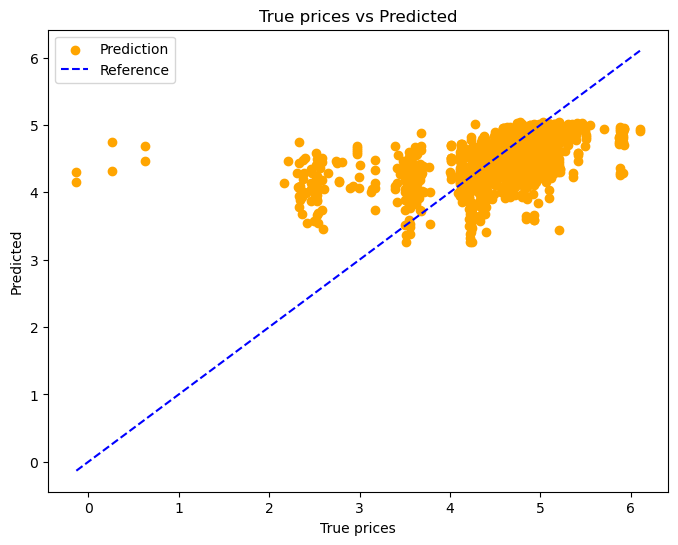

In [149]:
pipeline_ridge = Pipeline([
    ('scaler', RobustScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('ridge', Ridge(alpha=10, max_iter=1000))
])


pipeline_ridge.fit(x_multiple, prices_train)

ridgeResults = evaluate_model(pipeline_ridge, x_multiple_test, prices_test)
print_result_metrics(ridgeResults)

plot_results(ridgeResults['pred'], prices_test)



## Answering to some of the questions of the lab

### Discutir las implicaciones de los resultados.
### ¿Que factores parecen influir mas en los precios de la energıa? ¿Hay algunas limitaciones del modelo?

Seems like the factores that tend to impact more on the prediction of the prices are the day of the week, month and day.

Current limitations is the dataset, we might have a lot of rows but we need more data for each month. We might need more variables to see if that improves the accuracy of the model.

### ¿Cuáles son las horas del día que son más predecibles para su modelo?

#### Getting all the predictions for each hour

In [175]:
hourPrices = []
dataframeHours: pd.DataFrame = pd.DataFrame(columns=['RMSE'])
for hour in range(0, 24):
    data = dataframeAllData[dataframeAllData[hour_of_day_col] == hour].copy()
    #dataset_train, dataset_test, prices_train, prices_test = train_test_split(datasetToWork, salesPrices, test_size=0.2)
    datatrain, datatest, prices_train, prices_test = train_test_split(data, data[electricity_price_col], test_size=0.2)
    data_test = datatest[[month_col,hour_of_day_col, day_of_week_col]].values
    lassoResults = evaluate_model(pipeline_lasso, data_test, prices_test)
    print(f"RMSE para hora {hour} -> {lassoResults['RMSE']}")





RMSE para hora 0 -> 0.5282625829998913
RMSE para hora 1 -> 0.7619939436913032
RMSE para hora 2 -> 0.942581976652775
RMSE para hora 3 -> 0.8182001509482628
RMSE para hora 4 -> 0.7698083986179086
RMSE para hora 5 -> 0.716621748251934
RMSE para hora 6 -> 0.781683393277057
RMSE para hora 7 -> 0.6050639192776464
RMSE para hora 8 -> 0.6622174568539041
RMSE para hora 9 -> 0.6033461503988495
RMSE para hora 10 -> 0.41309744386951774
RMSE para hora 11 -> 0.4913429495949041
RMSE para hora 12 -> 0.5075522114446231
RMSE para hora 13 -> 0.5279460979975955
RMSE para hora 14 -> 0.5738425957320381
RMSE para hora 15 -> 0.606461348623369
RMSE para hora 16 -> 0.6759224131119476
RMSE para hora 17 -> 0.5711047733369905
RMSE para hora 18 -> 0.4928219216253205
RMSE para hora 19 -> 0.43531942355585634
RMSE para hora 20 -> 0.4764702157996418
RMSE para hora 21 -> 0.5263112870462494
RMSE para hora 22 -> 0.566690775496968
RMSE para hora 23 -> 0.9041196173846242


Seems more predictable hours are 0, 1, 2, 3, 4, 5, 7, 9, 23 Which have a RMSE greater than 0.60

### ¿Cuáles son las horas menos predecibles para su modelo?

Seems less predictable hours are 6, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22. Which have a RMSE greater than 0.60

### ¿Cómo afectan los cambios de temporadas de invierno/verano a su modelo?

### Demostrar que no se memorizaron los datos de entrenamiento

We can see that the RMSE error is approx 0.64, which left of with still a 36% of error.

### ¿cree que su modelo es lo suficientemente bueno?

No, because we didn't get a good RMSE error along with the suspicious metric of the R^2 which could mean we are having a big problem with the correlation of the variable, we require more data to train improve the model due to the results not being that good.